In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import seaborn as sns

/dsw/snapshots/snapshot_dsw_default_jupyter/python37/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
# Label: The hourly average gb per plan per scan at city-level
# Feature Set:
    #   avg(plans.driver_cancel_prob) as market_driver_cancel_prob,
    #   avg(plans.rider_cancel_prob) as market_rider_cancel_prob,
    #   avg(plans.spinner_cancel_prob) as market_spinner_cancel_prob,
    #   avg(plans.eta) as market_eta,
    #   avg(plans.surge_mul) as market_surge_mul,
    #   avg(completed.client_upfront_fare_usd) as market_gb,

    #   avg(plans.eta_one) as market_eta_one,  -- (1 - eta/1500)
    #   avg(plans.eta_square) as market_eta_square,  -- (1 - eta/1500)**2
    #   avg(plans.eta_cube) as market_eta_cube,  -- (1 - eta/1500)**3
    #   avg(plans.network_contention_2) as market_network_contention_2,  -- 1 / (1 + surge_mul**2)
    #   avg(plans.network_contention_3) as market_network_contention_3,  -- 1 / (1 + surge_mul**3)
    #   avg(plans.network_contention_5) as market_network_contention_5,  -- 1 / (1 + surge_mul**5)

    #   avg(plans.cr_ratio) as market_cr_ratio,  -- (1.0 - mgv.driver_cancel_prob) * (1.0 - mgv.rider_cancel_prob) * (1.0 - mgv.spinner_cancel_prob)

    #   avg(plans.eta_one * plans.cr_ratio) as market_eta_one_cr_ratio,
    #   avg(plans.eta_square * plans.cr_ratio) as market_eta_square_cr_ratio,
    #   avg(plans.eta_cube * plans.cr_ratio) as market_eta_cube_cr_ratio,
    #   avg(plans.network_contention_2 * plans.eta_one) as market_network_2_eta_1,
    #   avg(plans.network_contention_3 * plans.eta_one) as market_network_3_eta_1,
    #   avg(plans.network_contention_5 * plans.eta_one) as market_network_5_eta_1,
    #   avg(plans.network_contention_2 * plans.eta_square) as market_network_2_eta_2,
    #   avg(plans.network_contention_3 * plans.eta_square) as market_network_3_eta_2,
    #   avg(plans.network_contention_5 * plans.eta_square) as market_network_5_eta_2,
    #   avg(plans.network_contention_2 * plans.eta_cube) as market_network_2_eta_3,
    #   avg(plans.network_contention_3 * plans.eta_cube) as market_network_3_eta_3,
    #   avg(plans.network_contention_5 * plans.eta_cube) as market_network_5_eta_3,
    #   avg((1 - plans.network_contention_2) * plans.cr_ratio) as market_network_2_cr_ratio,
    #   avg((1 - plans.network_contention_3) * plans.cr_ratio) as market_network_3_cr_ratio,
    #   avg((1 - plans.network_contention_5) * plans.cr_ratio) as market_network_5_cr_ratio,
    #   avg(plans.eta_one * plans.network_contention_2 * plans.cr_ratio) as market_network_2_eta_1_cr_ratio,
    #   avg(plans.eta_one * plans.network_contention_3 * plans.cr_ratio) as market_network_3_eta_1_cr_ratio,
    #   avg(plans.eta_one * plans.network_contention_5 * plans.cr_ratio) as market_network_5_eta_1_cr_ratio,
    #   avg(plans.eta_square * plans.network_contention_2 * plans.cr_ratio) as market_network_2_eta_2_cr_ratio,
    #   avg(plans.eta_square * plans.network_contention_3 * plans.cr_ratio) as market_network_3_eta_2_cr_ratio,
    #   avg(plans.eta_square * plans.network_contention_5 * plans.cr_ratio) as market_network_5_eta_2_cr_ratio,
    #   avg(plans.eta_cube * plans.network_contention_2 * plans.cr_ratio) as market_network_2_eta_3_cr_ratio,
    #   avg(plans.eta_cube * plans.network_contention_3 * plans.cr_ratio) as market_network_3_eta_3_cr_ratio,
    #   avg(plans.eta_cube * plans.network_contention_5 * plans.cr_ratio) as market_network_5_eta_3_cr_ratio,
    #   avg(plans.eta_one * (1 - plans.network_contention_2) * plans.cr_ratio * completed.client_upfront_fare_usd) as market_network_2_eta_1_gb_cr_ratio,
    #   avg(plans.eta_one * (1 - plans.network_contention_3) * plans.cr_ratio * completed.client_upfront_fare_usd) as market_network_3_eta_1_gb_cr_ratio,
    #   avg(plans.eta_one * (1 - plans.network_contention_5) * plans.cr_ratio * completed.client_upfront_fare_usd) as market_network_5_eta_1_gb_cr_ratio,
    #   avg(plans.eta_square * (1 - plans.network_contention_2) * plans.cr_ratio * completed.client_upfront_fare_usd) as market_network_2_eta_2_gb_cr_ratio,
    #   avg(plans.eta_square * (1 - plans.network_contention_3) * plans.cr_ratio * completed.client_upfront_fare_usd) as market_network_3_eta_2_gb_cr_ratio,
    #   avg(plans.eta_square * (1 - plans.network_contention_5) * plans.cr_ratio * completed.client_upfront_fare_usd) as market_network_5_eta_2_gb_cr_ratio,
    #   avg(plans.eta_cube * (1 - plans.network_contention_2) * plans.cr_ratio * completed.client_upfront_fare_usd) as market_network_2_eta_3_gb_cr_ratio,
    #   avg(plans.eta_cube * (1 - plans.network_contention_3) * plans.cr_ratio * completed.client_upfront_fare_usd) as market_network_3_eta_3_gb_cr_ratio,
    #   avg(plans.eta_cube * (1 - plans.network_contention_5) * plans.cr_ratio * completed.client_upfront_fare_usd) as market_network_5_eta_3_gb_cr_ratio

In [3]:
# Read in data: features & labels
df_features_dict = {}
df_labels_dict = {}

for i in range(1, 11):
    df_features_dict[i] = pd.read_csv(f'version_3_features_{i}.csv')
    df_labels_dict[i] = pd.read_csv(f'labels_{i}.csv')

In [4]:
df_features_frames = [df_features_dict[1], df_features_dict[2], df_features_dict[3],
                      df_features_dict[4], df_features_dict[5], df_features_dict[6],
                      df_features_dict[7], df_features_dict[8], df_features_dict[9],
                      df_features_dict[10]]

df_labels_frames = [df_labels_dict[1], df_labels_dict[2], df_labels_dict[3],
                    df_labels_dict[4], df_labels_dict[5], df_labels_dict[6],
                    df_labels_dict[7], df_labels_dict[8], df_labels_dict[9],
                    df_labels_dict[10]]

df_features = pd.concat(df_features_frames, ignore_index=True)
df_labels = pd.concat(df_labels_frames, ignore_index=True)

df_features.drop('num_plans', axis=1, inplace=True)
df_labels.drop('num_plans', axis=1, inplace=True)

df = pd.merge(df_features, df_labels,
              how='left',
              left_on=['datestr', 'city_id', 'hour_of_day'],
              right_on=['datestr', 'city_id', 'hour_of_day']
             )

In [5]:
y = df['hour_gb']
X = df.loc[:, ['market_driver_cancel_prob',
                'market_surge_mul',
                'market_eta_one',
                'market_eta_square',
                'market_eta_cube',
                'market_eta_one_cr_ratio',
                'market_eta_square_cr_ratio',
                'market_eta_cube_cr_ratio',
                'market_network_2_eta_1',
                'market_network_3_eta_1',
                'market_network_5_eta_1',
                'market_network_2_eta_2',
                'market_network_3_eta_2',
                'market_network_5_eta_2',
                'market_network_2_eta_3',
                'market_network_3_eta_3',
                'market_network_5_eta_3',
                'market_network_2_cr_ratio',
                'market_network_3_cr_ratio',
                'market_network_5_cr_ratio',
                'market_network_2_eta_1_cr_ratio',
                'market_network_3_eta_1_cr_ratio',
                'market_network_5_eta_1_cr_ratio',
                'market_network_2_eta_2_cr_ratio',
                'market_network_3_eta_2_cr_ratio',
                'market_network_5_eta_2_cr_ratio',
                'market_network_2_eta_3_cr_ratio',
                'market_network_3_eta_3_cr_ratio',
                'market_network_5_eta_3_cr_ratio',
                'market_network_2_eta_1_gb_cr_ratio',
                'market_network_3_eta_1_gb_cr_ratio',
                'market_network_5_eta_1_gb_cr_ratio',
                'market_network_2_eta_2_gb_cr_ratio',
                'market_network_3_eta_2_gb_cr_ratio',
                'market_network_5_eta_2_gb_cr_ratio',
                'market_network_2_eta_3_gb_cr_ratio',
                'market_network_3_eta_3_gb_cr_ratio',
                'market_network_5_eta_3_gb_cr_ratio'
              ]
          ]

In [6]:
# Scale y
y = y / 10

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96)

In [8]:
lasso = Lasso(random_state=9)
lasso.set_params(alpha=0.001)
lasso.fit(X_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=9,
   selection='cyclic', tol=0.0001, warm_start=False)

In [9]:
lasso.intercept_

1.9670904666113906

In [10]:
lasso.coef_

array([ 0.6609811 , -0.35794727, -2.12874354, -0.        , -0.        ,
       -0.        ,  0.        ,  0.07515281, -0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.4102098 ,
        0.        , -0.        ,  0.        , -0.        , -0.07212319,
        0.        , -0.        , -0.        ])

In [11]:
pd.Series(lasso.coef_, index = X_train.columns )

market_driver_cancel_prob             0.660981
market_surge_mul                     -0.357947
market_eta_one                       -2.128744
market_eta_square                    -0.000000
market_eta_cube                      -0.000000
market_eta_one_cr_ratio              -0.000000
market_eta_square_cr_ratio            0.000000
market_eta_cube_cr_ratio              0.075153
market_network_2_eta_1               -0.000000
market_network_3_eta_1               -0.000000
market_network_5_eta_1                0.000000
market_network_2_eta_2               -0.000000
market_network_3_eta_2                0.000000
market_network_5_eta_2                0.000000
market_network_2_eta_3                0.000000
market_network_3_eta_3                0.000000
market_network_5_eta_3                0.000000
market_network_2_cr_ratio            -0.000000
market_network_3_cr_ratio            -0.000000
market_network_5_cr_ratio            -0.000000
market_network_2_eta_1_cr_ratio       0.000000
market_networ

In [12]:
y = df['hour_gb']
X = df.loc[:, ['market_driver_cancel_prob',
                'market_surge_mul',
                'market_eta_one',
                'market_eta_cube_cr_ratio',
                'market_network_2_eta_1_gb_cr_ratio',
                'market_network_5_eta_2_gb_cr_ratio'
              ]
          ]

In [13]:
# Scale y
y = y / 10

# Add intercept to X
X['intercept'] = [1 for _ in range(len(X.index))]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=96)

In [15]:
# Model Training
model = sm.OLS(y_train, X_train)

In [16]:
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:                hour_gb   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     5248.
Date:                Thu, 11 Aug 2022   Prob (F-statistic):               0.00
Time:                        03:43:45   Log-Likelihood:                -1110.0
No. Observations:                9343   AIC:                             2234.
Df Residuals:                    9336   BIC:                             2284.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
mark

In [17]:
# Train RMSE
y_train_pred = trained_model.predict(X_train)
train_rmse = np.sqrt(np.mean((y_train - y_train_pred)**2))
train_rmse

0.2724955329364531

In [18]:
# Test RMSE
y_test_pred = trained_model.predict(X_test)
test_rmse = np.sqrt(np.mean((y_test - y_test_pred)**2))
test_rmse

0.2829222869794015

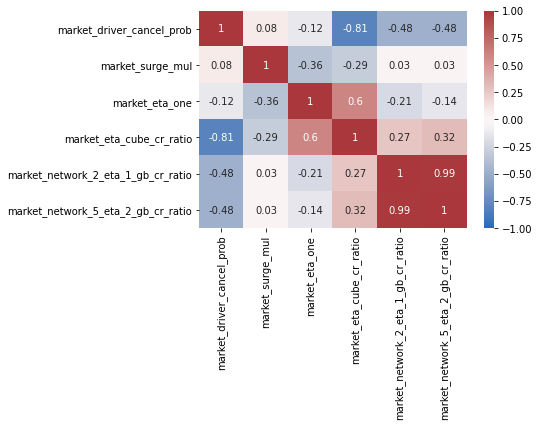

In [19]:
# Visualizing a Pandas Correlation Matrix
corr_matrix = X.loc[:, X.columns != 'intercept'].corr().round(2)
sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.show()